# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from pandas.io.json import json_normalize
import json
import geopandas
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import preprocessing
from sklearn.cluster import KMeans
from IPython.display import display
import folium
from sodapy import Socrata
import lxml
from shapely.geometry import Point, Polygon, MultiPolygon, shape, MultiPoint
import shapely.wkt
from shapely.wkt import dumps, load
import reverse_geocoder as rg 

### Issues with SSL certificates when trying to make an API call
I had some issues when I tryed to call an API. The code bellow solved the issues

In [2]:
import os
import os.path
import ssl
import stat
import subprocess
import sys

STAT_0o775 = ( stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR
             | stat.S_IRGRP | stat.S_IWGRP | stat.S_IXGRP
             | stat.S_IROTH |                stat.S_IXOTH )


def main():
    openssl_dir, openssl_cafile = os.path.split(
        ssl.get_default_verify_paths().openssl_cafile)

    print(" -- pip install --upgrade certifi")
    subprocess.check_call([sys.executable,
        "-E", "-s", "-m", "pip", "install", "--upgrade", "certifi"])

    import certifi

    # change working directory to the default SSL directory
    os.chdir(openssl_dir)
    relpath_to_certifi_cafile = os.path.relpath(certifi.where())
    print(" -- removing any existing file or link")
    try:
        os.remove(openssl_cafile)
    except FileNotFoundError:
        pass
    print(" -- creating symlink to certifi certificate bundle")
    os.symlink(relpath_to_certifi_cafile, openssl_cafile)
    print(" -- setting permissions")
    os.chmod(openssl_cafile, STAT_0o775)
    print(" -- update complete")

if __name__ == '__main__':
    main()

 -- pip install --upgrade certifi
 -- removing any existing file or link
 -- creating symlink to certifi certificate bundle
 -- setting permissions
 -- update complete


# Visualizing Manhattan map

In [3]:
Lat = 40.78343   #Latitude
Long = -73.96625 #Longitude
map_NY = folium.Map(location=[Lat, Long], zoom_start=13) #call Folium to creat the map
display(map_NY)

# Manhattan neighborhoods
I took this code from the course in order to name the neighborhood in manhattan and to get their coordinates. However I didn't find in this data the boundaries geometry in order to make choropleth map for the next steps of the project.

In [4]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

dataNYU = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/nyu-2451-34572-geojson.json'
with open(dataNYU) as f:
    js = json.load(f)
    
for data in js['features']:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


# Manhattan Neighborhood Tabulation Areas (NTA)
I found a geojson file for neighborhood geometry on <a title="NYC Open Data website" href="https://opendata.cityofnewyork.us"> NYC Open Data website</a>. It's the official areas of NYC called Neighborhood Tabulation Areas.

In [5]:
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson'
with open(dat) as f:
    js = json.load(f)
tmp = []
for i in js['features']:
    if i['properties']['boro_name'] == 'Manhattan':
        tmp.append(i)        
tmp2 = {"type": "FeatureCollection", "features": tmp}
with open('/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson', 'w') as file:
    json.dump(tmp2,file)

# 1. First factor: Crime rate
In order to visualize the crime rate, I had to call an API published by NYC open data from <a title="Socrata" href="https://dev.socrata.com/publishers/"> Socrata</a>. So first of all it was necessary to create a Socrata account, then call the API with specific parameters in order to reduce the data size downloaded.

In [6]:
client = Socrata("data.cityofnewyork.us",None)
results = client.get("qgea-i56i",
                     boro_nm = "MANHATTAN", # Only crime occured in Manhattan
                     where="rpt_dt between '2016-01-01T00:00:00.000' and '2017-01-01T00:00:00.000'", #Crimes during the year 2016
                     limit=100000) #The first 100000 crimes of 2016

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
crime_manhattan = results_df[['addr_pct_cd','rpt_dt','ofns_desc','boro_nm','latitude','longitude']]
crime_manhattan.rename(columns={'addr_pct_cd' : 'Precinct',
                                'rpt_dt':'Date',
                                'ofns_desc':'Description',
                                'boro_name':'Borough'})

,Precinct,Date,Description,boro_nm,latitude,longitude
0,32,2016-02-21T00:00:00.000,FELONY ASSAULT,MANHATTAN,40.809413199,-73.944367164
1,10,2016-04-25T00:00:00.000,PETIT LARCENY,MANHATTAN,40.739161316,-74.001105672
2,1,2016-07-24T00:00:00.000,PETIT LARCENY,MANHATTAN,40.704832415,-74.006901091
3,6,2016-07-14T00:00:00.000,THEFT-FRAUD,MANHATTAN,40.73876604,-74.002927983
4,10,2016-10-21T00:00:00.000,DANGEROUS DRUGS,MANHATTAN,40.748408387,-73.999940095
...,...,...,...,...,...,...
99995,1,2016-04-27T00:00:00.000,OFF. AGNST PUB ORD SENSBLTY &,MANHATTAN,40.702556525,-74.012570415
99996,10,2016-08-09T00:00:00.000,THEFT-FRAUD,MANHATTAN,40.744335142,-74.002906575
99997,1,2016-09-15T00:00:00.000,PETIT LARCENY,MANHATTAN,40.701694767,-74.011628946
99998,28,2016-09-27T00:00:00.000,SEX CRIMES,MANHATTAN,40.808749904,-73.952585806


### Sorting crime by neighborhoods
The issues with the crimes data is there is no neighborhood name but only their coordinates. In order to sort them by neighborhood I wrote the code bellow.
This code works with shapely library. It basically find in which neighborhood occured the crime number <i>j</i> at the coordinates 'Latitude' 'Longitude'.

In [7]:
# construct point based on lon/lat returned by geocoder
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson' # Pathname of the geojson file
Neighborhood = pd.DataFrame(columns = {'Neighborhood'}) #Make an empty dataFrame with one column named Neighborhoods
with open(dat) as f:
     js = json.load(f) #Load the neighborhood area geojson file
for j in range(0,100000): #for the crime number j
    point = Point(float(crime_manhattan.iloc[j]['longitude']),float(crime_manhattan.iloc[j]['latitude'])) #Define a point with the crime coordinates
    
    # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            Neighborhood = Neighborhood.append({'Neighborhood': feature['properties']['ntaname']}, 
                                              ignore_index = True)

### Counting the number of occurence of each neighborhood
That will give us the number of crime in each neighborhood

In [8]:
values = Neighborhood['Neighborhood'].value_counts().keys().tolist()
counts = Neighborhood['Neighborhood'].value_counts().tolist()
Crime_Rate_Neighborhood = pd.DataFrame({'Neighborhood' : values, 'Crimes' : counts})

### Visualizaing the crime rate map

In [9]:
thresholds = np.linspace(0,10090,10,counts)
thresholds = list(thresholds)
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson'

with open(dat) as f:
    js = json.load(f)
crime_NY = folium.Map(location=[Lat, Long],zoom_start=13)
crime_NY.choropleth(
 geo_data=js,
 name='choropleth',
 data=Crime_Rate_Neighborhood,
 columns=['Neighborhood','Crimes'],
 key_on='feature.properties.ntaname',
 fill_color='Reds',
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='Crimes repartition for the 100000 first crimes in 2016',
 threshold_scale=thresholds
)
crime_NY

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


# 2. Second factor: Population density
I downloaded the population density by NTA on the NYC open data website. The data comes from the census in 2000 and 2010 for all borough. In order to be the closest to the today's population density I obviously took the population density in 2010 only on Manhattan.

In [10]:
Population_rate = pd.read_csv('/Users/Samuel/Desktop/Logiciels/Capstone_Exams/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
Population_rate = Population_rate[Population_rate['Year']==2010]
Population_rate = Population_rate[Population_rate['Borough']=='Manhattan']
Population_rate

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
284,Manhattan,2010,61,MN01,Marble Hill-Inwood,46746
285,Manhattan,2010,61,MN03,Central Harlem North-Polo Grounds,75282
286,Manhattan,2010,61,MN04,Hamilton Heights,48520
288,Manhattan,2010,61,MN06,Manhattanville,22950
289,Manhattan,2010,61,MN09,Morningside Heights,55929
290,Manhattan,2010,61,MN11,Central Harlem South,43383
291,Manhattan,2010,61,MN12,Upper West Side,132378
292,Manhattan,2010,61,MN13,Hudson Yards-Chelsea-Flat Iron-Union Square,70150
293,Manhattan,2010,61,MN14,Lincoln Square,61489
294,Manhattan,2010,61,MN15,Clinton,45884


### Visualizing the population density map

In [11]:
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson'
thresholds = np.linspace(0,132378,10,counts)
thresholds = list(thresholds)


with open(dat) as f:
    js = json.load(f)
population_NY = folium.Map(location=[Lat, Long],zoom_start=13)
population_NY.choropleth(
 geo_data=js,
 name='choropleth',
 data=Population_rate,
 columns=['NTA Name','Population'],
 key_on='feature.properties.ntaname',
 fill_color='Purples',
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='Population according to the 2010 Census',
 threshold_scale = thresholds
)
population_NY

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


# 3. Third factor: the proximity to a university

I looked every venues related to the keyword 'University' in each neighborhoods by doing a Foursquare request. Then I put all the venues in a dataFrame

In [12]:
CLIENT_ID = '2RFQUSPMDSLUAFS0WKVU20TEUXGIHEOOBXIGA4UMZEJZ15VL'
CLIENT_SECRET = 'BJ2JZMJUPTVHZPAJ2THEWGWQ33S2FFSGPTU1YU2JUZP4CPZ1'
LIMIT = 2000
VERSION = 20180406
radius = 500
names = manhattan_data['Neighborhood']
latitudes = manhattan_data['Latitude']
longitudes = manhattan_data['Longitude']
university = pd.DataFrame()

for name, lat, lng in zip(names, latitudes, longitudes):
    url_university = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,lat,lng,VERSION,'University',radius,LIMIT)
    results = requests.get(url_university).json()["response"]['venues']
    for v in results:
        university = university.append({'Neighborhood':name, 
                                        'Latitude': lat, 
                                        'Longitude': lng, 
                                        'Name': v['name'], 
                                        'Univ Lat': v['location']['lat'], 
                                        'Univ Lon': v['location']['lng']},ignore_index=True)

### Checking the data

In [13]:
university

,Latitude,Longitude,Name,Neighborhood,Univ Lat,Univ Lon
0,40.876551,-73.910660,Campbell Sports Center - Columbia University,Marble Hill,40.871588,-73.914377
1,40.876551,-73.910660,Columbia University Softball Field,Marble Hill,40.873647,-73.914100
2,40.876551,-73.910660,Baker Athletic Complex,Marble Hill,40.872061,-73.914876
3,40.715618,-73.994279,99 University,Chinatown,40.719864,-73.994264
4,40.851903,-73.936900,Yeshiva University - Gottesman Swimming Pool,Washington Heights,40.851663,-73.930299
...,...,...,...,...,...,...
390,40.739673,-73.990947,Sheila C. Johnson Design Center (Parsons The N...,Flatiron,40.735161,-73.994169
391,40.739673,-73.990947,NYU 105 E 17th St,Flatiron,40.736264,-73.988226
392,40.739673,-73.990947,NYU School of Professional Studies,Flatiron,40.734436,-73.993801
393,40.756658,-74.000111,University Tutor - New York,Hudson Yards,40.754824,-73.994385


### Ploting all the venues on the map

In [14]:
Coordinates = []
Venues = folium.Map(location=[Lat, Long], zoom_start=13) #call Folium to creat the map
for name, lat, lng in zip(university['Name'], university['Univ Lat'], university['Univ Lon']):
    label = folium.Popup(name, parse_html=True)
    Coordinates.append((lat,lng))
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Venues)
    
Venues

### Clustering
We can observe the venues are grouped into differents clusters

In [15]:
k_means = KMeans(init="k-means++", n_clusters=8, n_init=12)
k_means.fit(Coordinates)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
df = pd.DataFrame()
df['Labels'] = k_means_labels

In [16]:
tmp1 = df['Labels'].unique()
tmp2 = df['Labels'].value_counts().tolist()
df2 = {'Labels':list(df['Labels'].unique()),'Centroid':list(k_means.cluster_centers_),
            'Size':df['Labels'].value_counts().tolist()}

In [17]:
clusters = pd.DataFrame(data=df2)

In [18]:
clusters

,Labels,Centroid,Size
0,3,"[40.80947344667175, -73.96155229623874]",84
1,5,"[40.74971988881043, -73.98658940245706]",82
2,0,"[40.711565017577925, -74.00673435074562]",62
3,4,"[40.86136781151444, -73.92354041457705]",56
4,6,"[40.764271572480396, -73.95665991128062]",38
5,1,"[40.7309217538401, -73.99487212020662]",35
6,7,"[40.77144480045935, -73.98473788229106]",28
7,2,"[40.74888765197545, -73.9749021579681]",10


In [19]:
# construct point based on lon/lat returned by geocoder
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson' # Pathname of the geojson file
clusters_hood = pd.DataFrame(columns = {'Neighborhood'}) #Make an empty dataFrame with one column named Neighborhoods
with open(dat) as f:
     js = json.load(f) #Load the neighborhood area geojson file
        
for i in range(0,7): #for the crime number j
    point = Point(clusters['Centroid'].iloc[i][1], clusters['Centroid'].iloc[i][0]) #Define a point with the crime coordinates
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            clusters_hood = clusters_hood.append({'Neighborhood': feature['properties']['ntaname']}, 
                                              ignore_index = True)
clusters = pd.concat([clusters, clusters_hood], axis=1)
clusters

,Labels,Centroid,Size,Neighborhood
0,3,"[40.80947344667175, -73.96155229623874]",84,Morningside Heights
1,5,"[40.74971988881043, -73.98658940245706]",82,Midtown-Midtown South
2,0,"[40.711565017577925, -74.00673435074562]",62,Battery Park City-Lower Manhattan
3,4,"[40.86136781151444, -73.92354041457705]",56,Marble Hill-Inwood
4,6,"[40.764271572480396, -73.95665991128062]",38,Lenox Hill-Roosevelt Island
5,1,"[40.7309217538401, -73.99487212020662]",35,West Village
6,7,"[40.77144480045935, -73.98473788229106]",28,Lincoln Square
7,2,"[40.74888765197545, -73.9749021579681]",10,NaN


In [20]:
clusters.dropna(inplace = True)
clusters

,Labels,Centroid,Size,Neighborhood
0,3,"[40.80947344667175, -73.96155229623874]",84,Morningside Heights
1,5,"[40.74971988881043, -73.98658940245706]",82,Midtown-Midtown South
2,0,"[40.711565017577925, -74.00673435074562]",62,Battery Park City-Lower Manhattan
3,4,"[40.86136781151444, -73.92354041457705]",56,Marble Hill-Inwood
4,6,"[40.764271572480396, -73.95665991128062]",38,Lenox Hill-Roosevelt Island
5,1,"[40.7309217538401, -73.99487212020662]",35,West Village
6,7,"[40.77144480045935, -73.98473788229106]",28,Lincoln Square


In [21]:
clus = folium.Map(location=[Lat, Long], zoom_start=13) #call Folium to creat the map
for i in range(0,7):
    a = list(clusters['Centroid'].iloc[i])
    lat = a[0]
    lng = a[1]
    s = int(clusters['Size'].iloc[i])/1.5
    folium.CircleMarker(
            location = [lat,lng],
            radius=s,
            popup=clusters['Neighborhood'].iloc[i],
            color=None,
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7).add_to(clus)
clus

### Neighborhoods selection
We can observe that the bigest clusters are located in 7 differents neighborhood:

- Marble Hill-Inwood
- Morningside Heights
- Lincoln Square
- Midtown-Midtown South
- Lenox Hill-Roosevelt Island
- SoHo-TrBeCa-Civic Center-Little Italy

So let's explore more closely those neighborhoods

# 4. Fourth factor: the gross rent price in the neighborhoods

### Data acquisition and reorganisation
I downloaded the gross rent price for the 6 neighborhood on the NYC Open Data website

In [22]:
Rent_prices = pd.read_csv('/Users/Samuel/Desktop/Rents.csv')
Rent_prices

,Neighborhood,Price
0,Marble Hill-Inwood,1279
1,Morningside Heights,1575
2,Lincoln Square,2391
3,Midtown-Midtown South,2951
4,Lenox Hill-Roosevelt Island,2289
5,Battery Park City-Lower Manhattan,3228
6,West Village,2337


In order to make a choropleth map with only the 6 neighborhood of interest I had to reorganise the geojson file of the NTA geometry and save it into a new file called 'District_2.gejson'

In [23]:
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson'
with open(dat) as f:
    js = json.load(f)
tmp = []
for i in js['features']:
    for Neighborhood in Rent_prices['Neighborhood']:
        if i['properties']['ntaname'] == Neighborhood:
            tmp.append(i)        
tmp2 = {"type": "FeatureCollection", "features": tmp}
with open('/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts_2.geojson', 'w') as file:
    json.dump(tmp2,file)

### Visualizing data on the map

In [25]:
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts_2.geojson'
with open(dat) as f:
    js = json.load(f)
    
thresholds = np.linspace(1000,Rent_prices['Price'].max(),6)
thresholds = list(thresholds)
Price_Rent = folium.Map(location=[Lat, Long],zoom_start=13)
Price_Rent.choropleth(
 geo_data=js,
 name='choropleth',
 data=Rent_prices,
 columns=['Neighborhood','Price'],
 key_on='feature.properties.ntaname',
 fill_color='Reds',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Median of gross rent price in $',
 threshold_scale = thresholds
)
Price_Rent

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


# 5. Attractivity
Among the six neighborhood I calculated an "attractivity index" which is for each neighborhood: 
(Population Number/(Crime rate + Rent price))+number of venues. Then the values were normalized in order to compare the 6 neighborhood.
Higher is the index, more attractive is the neighborhood for the business. The final choice will be according to this index which merge all together the different factors.

In [66]:
Crime_neighborhood_selected = pd.DataFrame()
Population_neighborhood_selected = pd.DataFrame()
coord = []

for j in js['features'][0]['geometry']['coordinates']:
    poly1 = shape({"type" : "MultiPolygon","coordinates":[j]})
    testing = poly1.within(polygon)
    if testing == True:
        coord.append(j)

for Neighborhood in Rent_prices['Neighborhood']:
    Crime_neighborhood_selected = Crime_neighborhood_selected.append(
        Crime_Rate_Neighborhood[Crime_Rate_Neighborhood['Neighborhood'] == Neighborhood],
        ignore_index=True
    )
    Population_neighborhood_selected = Population_neighborhood_selected.append(
        Population_rate[Population_rate['NTA Name'] == Neighborhood], 
        ignore_index=True
    )
    
test = pd.merge(Rent_prices,clusters,on='Neighborhood',how='outer')
Attractivity = {'Neighborhood' : tmp['Neighborhood'],'Attractivity index' : (tmp2['Population'] / (tmp['Crimes'] + Rent_prices['Price']))+test['Size']}
Attractivity = pd.DataFrame(Attractivity)

# Create x, where x the 'scores' column's values as floats
x = Attractivity[['Attractivity index']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
Normalized_val = min_max_scaler.fit_transform(x)
Attractivity['Attractivity index'] = Normalized_val
Attractivity

,Neighborhood,Attractivity index
0,Marble Hill-Inwood,0.501245
1,Morningside Heights,1.000000
2,Lincoln Square,0.000000
3,Midtown-Midtown South,0.736907
4,Lenox Hill-Roosevelt Island,0.313703
5,Battery Park City-Lower Manhattan,0.471185
6,West Village,0.071865


### Visualization of the attractivity on the map

In [67]:
dat = '/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts_2.geojson'
with open(dat) as f:
    js = json.load(f)
    
thresholds = np.linspace(Attractivity['Attractivity index'].min(),Attractivity['Attractivity index'].max(),6)
thresholds = list(thresholds)
thresholds

#Rent = folium.Map(location=[Lat, Long],zoom_start=13)
Price_Rent = folium.Map(location=[Lat, Long],zoom_start=13)
Price_Rent.choropleth(
 geo_data=js,
 name='choropleth',
 data=Attractivity,
 columns=['Neighborhood','Attractivity index'],
 key_on='feature.properties.ntaname',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Attractivity',
 threshold_scale = thresholds
)
Price_Rent

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [39]:
with open('/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Primary Commercial Zoning by lot.geojson') as f1:
    js1 = json.load(f1)
with open('/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Districts.geojson') as f2:
     js2 = json.load(f2)


In [40]:
for i in js2['features']:
    if i['properties']['ntaname'] == 'Morningside Heights':
        test = i['geometry']

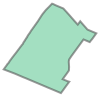

In [41]:
polygon = shape(test)
polygon

In [42]:
coord = []
for j in js1['features'][0]['geometry']['coordinates']:
    poly1 = shape({"type" : "MultiPolygon","coordinates":[j]})
    testing = poly1.within(polygon)
    if testing == True:
        coord.append(j)
file = {
  "type": "FeatureCollection",
  "features": [
    {"type":"Feature",
     
     "properties":{"borough":"MN",
                   "objectid":"1",
                   "version":"05D",
                   "zonedist1":"R10A"},
     
     "geometry":{"type":"MultiPolygon","coordinates":coord}}]
}

In [43]:
with open('/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Primary Commercial Zoning by lot_2.geojson', 'w') as f:
    json.dump(file,f)

In [44]:
for i in js['features'][0]['geometry']['coordinates']:
    
    for Neighborhood in Rent_prices['Neighborhood']:
        if i['properties']['ntaname'] == Neighborhood:
            tmp.append(i) 

In [123]:
MS_Lat = 40.808000
MS_Long = -73.963896
with open('/Users/Samuel/Desktop/Logiciels/Capstone_Exams/Primary Commercial Zoning by lot_2.geojson') as f:
     js = json.load(f)
commercial = folium.Map(location=[MS_Lat, MS_Long],zoom_start=15)
folium.features.Choropleth(js, data=None,
                           columns=None, 
                           key_on=None, 
                           bins=6, 
                           fill_color='#ff00ff', 
                           nan_fill_color=None, 
                           fill_opacity=0.6,
                           nan_fill_opacity=None, 
                           line_color=None, 
                           line_weight=1, 
                           line_opacity=1, 
                           name=None, 
                           legend_name='Commercial Zoning by lot', 
                           overlay=False,
                           control=True, 
                           show=True, 
                           topojson=None, 
                           smooth_factor=None, 
                           highlight=None).add_to(commercial)
commercial

In [122]:
LIMIT = 300
VERSION = 20190406
radius = 200
venues_of_interest = pd.DataFrame()
url_MS = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,MS_Lat,MS_Long,VERSION,'computer science',radius,LIMIT)
query_results = requests.get(url_MS).json()["response"]['venues']
for v in results:
    venues_of_interest = venues_of_interest.append({'Name': v['name'], 
                                    'Lat': v['location']['lat'], 
                                    'Lon': v['location']['lng']},ignore_index=True)

In [120]:
venues_of_interest

,Lat,Lon,Name
0,40.808699,-73.964232,North West Science
1,40.808749,-73.963727,Barnard Computer Lab
2,40.807240,-73.963530,Lerner Hall - Computer Lab
3,40.807526,-73.962712,Butler CUIT Computer LAB
4,40.809433,-73.963239,Diana Computer Lab
5,40.808703,-73.962007,UP Computer Lab
6,40.809844,-73.963268,Lehman Computer Lab
7,40.808224,-73.961834,"Graduate School of Arts and Sciences, Columbia..."


In [124]:
Coordinates = []
for name, lat, lng in zip(venues_of_interest['Name'], 
                          venues_of_interest['Lat'],
                          venues_of_interest['Lon']):
    label = folium.Popup(name, parse_html=True)
    Coordinates.append((lat,lng))
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FFBF00',
        fill_opacity=1,
        parse_html=True).add_to(commercial)

commercial